# **Convolutional Neural Network Classifier with Residual Connections**

In this notebook, I explore the capabilities of a Convolutional Neural Network (CNN) in classifying images. However, departing from thec basic sequential CNN architecture, the model I use features residual connections, which have been shown to lead substantial improvements in CNNs performance. 

**Convolutional Neural Network**

In order to understand Generative Adverserial Networks, one should first understand what Convolutional Neural Networks are, as they are the core building block of any image processing neural network.

Convolutional Neural Networks (CNNs) are a type of neural networks specifically developed for processing image data. They are suprisingly successful at detecting abstract features from an image, such as lines or edges, and by combining them into concrete form, they can develop a much richer understanding of the visual input than a regular Feedforward Neural Network (FNN) can.

An image can indeed be fed to a FNN in a vectorized form by converting the 2-dimesional pixel frame into a single long vector (e.g., 28x28 px image would be converted into a 784x1 px vector), but this has turned out to be a suboptimal approach. A FNN has a very hard time learning any meaningful concepts from an image, for instance, what constitutes a dog on an abstract level. If a dog is moved from the left side of an image to the right side, the FNN cannot distinguish the image containing a dog anymore. This happens mostly because the flattened vector does not preserve locality in the image: pixels appearing next to one another in the image, which together construct a relevant feature in the image, become dispersed in the flattened format.

Clearly, one would want a network to somehow actually learn the charcteristics of a dog, and identify it regardless of the location it appears in the image. CNNs were developed to solve this problem in particular. Instead of taking as input a flattened vector, a CNN processes the image in the grid format. Instead of a weight matrix, CNNs have "kernels", which are small, often 3x3 matrices. In each layer, these kernels are rolled over the input image, which produces the output of the layer. Similar to the weights in a FNN, the kernels are learned in the training phase. This operation preserves the locality in images, and allows the network to learn abstract features of the image, regardless of where they appear. The image below illustrates the very basic idea of kernels and convolutions:

![Convolution with a kernel](https://miro.medium.com/max/640/0*e-SMFTzO8r7skkpc)

While the convlution with kernels is the main gist of CNNs, there's obviously a vast amount of other details that I don't have the space to discuss here thoroughly. Some of them, such as Max Pooling, Strides, Padding, and Inverse Convolutions are discussed below when necessary for understanding the content of the notebook. However, for those interested in getting a more thorough conception of CNNs, I recommend [this Deep Mind x UCL introductory lecture](https://www.youtube.com/watch?v=shVKhOmT0HE&list=PLDWsBf9aYr5QkDmzOpCYBlDbvQhB4Blv3&index=38).

**Residual Connections**

Theoretically speaking, the deeper a neural network is, the more able it is to learn to perform a specific task. However, the deeper a neural network gets after a certain point, the more difficult it becomes to optimize. Thus, in practice, the depth of networks was limited to, say 20 to 30 layers. However, residual connections have turned out to be a solid fix for the issue, allowing successful training of significantly deeper networks, and thus, they are now a standard component in many neural network applications.

A residual connection is conceptually a relatively simple feature. At its core, a residual connection is is a direct connection from the earlier layers to latter parts of the network. In other words, this architecture provides another path for data to flow to the latter parts of the network, by skipping some layers. This is in stark contrast to the conventional sequential architecture, where each layer takes as input only the output of the previous layer.

The authors of the [paper that introduced residual connections](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) ask how is it possible that the performance of a network *degrades* when more layers added to a shallow network; after all, the deeper network should be capable of producing *at least* similar results as the shallow net, as it can be formulated as a combination of the trained shallow net, plus some additional layers that learn an identity function. 

They argue, that learning the identity function is surprisingly difficult due to, e.g., weight initialization with mean zero, weight decay, and other factors that bias the weights towards zero, rather than the identity. Thus, networks tend to be naturally good at learning a “zero function”, rather than the identity function.

The gist of the paper is to provide a solution for making the identity function, rather than the zero function, the default function of a network, and the solution turns out to be the residual connection. 

In fact, the residual connection *is* the identity function built directly into the architecture between some layers. Thus, the signal can always flow through it, if needed. Then, the actual weight layers - be it fully connected, convolutional, etc. - can learn what to change in the identity mapping.

**Notice, that because weight layers tend towards the zero function, the the identity function becomes the default function of the network.**

The picture below illustrates the basic architecture of a residual connection:

![Residual connection](https://miro.medium.com/max/640/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import math

In [2]:
# Assign device - check that CUDA is enabled
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# **Importing data**

The CIFAR-10 dataset is a well-known dataset containing 60,000 images from 10 different classes (shown below). The data are split into training and validation sets already beforehand, with the sets containing 50,000 and 10,000 images, respectively.

In [3]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

# Create a directory 
if not os.path.isdir('./data'):
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar: # Open for reading with gzip compression
        tar.extractall(path='./data')

data_dir = './data/cifar10'
classes = os.listdir(data_dir + '/train')

# Print folder and class names
print('Folders: ', os.listdir(data_dir))
print('Classes:', classes)

Using downloaded and verified file: ./cifar10.tgz
Folders:  ['train', 'test']
Classes: ['horse', 'dog', 'ship', 'frog', 'truck', 'deer', 'airplane', 'automobile', 'cat', 'bird']


# **Data preprocessing**

In this section, I
* Normalize the data
* Augment the data 
* Move it to dataloaders to facilitate training

Cleaning and balancing of the data is already taken care of, so there's no need for other procedures.

**Defining data augmentations operations (and other transformations)**

Data augmentation means modifying the original image data in various ways to impose artificial variation to it, and hence reduce the likelihood of overfitting. For instance, we may rotate or flip the images, adjust their colors, etc.

In addition, the performed transforms include turning the data into a tensors. This operation also takes the data from 0-255 range to 0-1 range.

Below, I define all augmentation and transforming operations that will be performed to the training data.

In [30]:
image_size = 32
train_tfms_list = [
    T.RandomCrop(image_size, padding=4, padding_mode='reflect'), # Resize image to 32x32 randomly cropping
    T.RandomHorizontalFlip(), # Mirror images
    T.RandomRotation(10), # Rotation of -10 to +10 degrees
    #T.RandomResizedCrop(25, scale=(0.5,0.9), ratio=(1, 1)), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Adjust colors randomly
    T.ToTensor() # Convert to tensor
]

**Finding normalization parameters**

In order to normalize the data, we need to find its mean and standard deviation. In this case, as we're working with 3-channel RGB images, we want to normalize each of the channels. Thus, we need the mean and standard deviation of each channel (post-augmentations), which is carried out by the function below.

Notice, in order to avoid information leakages from test to train set, we perform the normalization parameter search only using the train data. Both datasets are then normalized with these parameters.

In [6]:
def get_norm_stats(data_dir, tfms_list, image_size=32):
    '''
        E(X)  = sum(X) / len(X)
        SD(X) = SQRT( E(X^2) - E(X)^2 )
    '''
    
    tfms = T.Compose(tfms_list)
    ds   = ImageFolder(data_dir, tfms)
    dl   = DataLoader(ds, 400, shuffle=True, num_workers=2, pin_memory=True)

    # Placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    for images, labels in tqdm(dl): 

        # Images shape = (batch_size, n_channels, image_size, image_size)
        psum    += images.sum(axis=[0, 2, 3]) # We want mean value with respect to axis 1 
        psum_sq += (images ** 2).sum(axis=[0, 2, 3]) 
        
    
    denom = len(ds) * image_size ** 2

    # Mean and Std
    total_mean = psum / denom
    total_var  = (psum_sq / denom) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean_tuple = tuple(total_mean.tolist())
    std_tuple = tuple(total_std.tolist())

    return mean_tuple, std_tuple

In [7]:
stats = get_norm_stats(data_dir+'/train', train_tfms_list, image_size)
stats

100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


((0.4664835035800934, 0.4571327269077301, 0.4245508313179016),
 (0.2579056918621063, 0.2569158971309662, 0.2672043442726135))

**Data augmentation**

Below, I perform the actual augmentation and transformation operations to the training data, including normalization with the parameters computed above. Validation data is not augmented, only converted to tensors and normalized.


In [8]:
# Add normalization to transformations list
train_tfms_list.append(T.Normalize(*stats, inplace=True))
train_tfms = T.Compose(train_tfms_list)

# Validation data is not augmented - only turned to tensors and normalized
valid_tfms = T.Compose([
    T.ToTensor(), 
    T.Normalize(*stats)
    ])

# Create datasets with pre-defined transformations
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

**Moving data to dataloaders**

Dataloaders split the data into batches and store them in a loop-able form. That is, we can iterate over the dataloaders in the main training loop to obtain a batch of data at a time.

In [35]:
# Create data loader
batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, shuffle=False, num_workers=3, pin_memory=True)

**Showing a batch of images**

Below, is a random sample of 64 images drawn from the transformed data dataset (with color channels denormalized to original).

In [36]:
# Denormalize the image tensor
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1) # Create 1x3x1x1 tensor with the means of the R, G, and B channels
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)   # Same logic with standard deviations
    return images * stds + means # Reverse operation to (x - E[x]) / SD[x]

# Show a single batch of images
def show_batch(dl):
    for images, _ in dl:
        denorm_images = denormalize(images, *stats)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        grid = make_grid(denorm_images[:64], nrow=8) # Convert to grid shape
        ax.imshow(grid.permute(1, 2, 0).clamp(0,1)) # Our data is actually in BGR order, and imshow() assumes RGB ordering
        plt.show()
        break

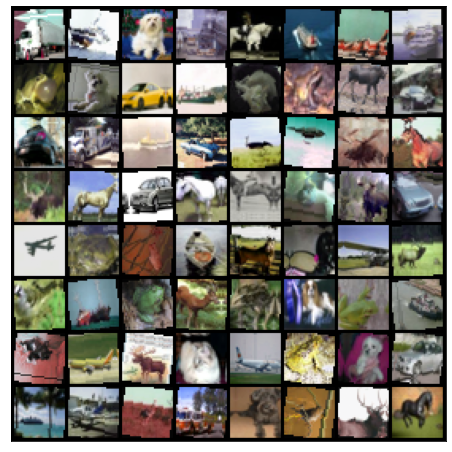

In [37]:
show_batch(train_dl)

# **Model architecture**

Below, I define the architecture of the neural network. As we work with regular image data, the rather obvious choice is to use the 2D-Convlutional layers. 

However, departing from the naive sequential CNN architecture, this model features residual connections over some of the convolutional layers (or blocks, to be more precise). In a sequential architecture, each layer takes as input only the output of the previous layer. In contrast, in ResNets, some of the layers take as input not only the output of the layer preceding it, but also the output of a layer(s) several steps earlier. This architecture provides another path for data to flow to the latter parts of the network, by skipping some layers.

Other network architecture details include
* **"Shape" of the network.** Following the convention with CNNs, each of the successive layers becomes increasingly deep and narrow. In this application, the number of channels is increased from 3 (RBG channels) to 512 (i.e., layers get deeper), but at the same time, the image dimensions are reduced from 32x32 to 1x1 (i.e., the layers get narrower).

* **MaxPooling.** Max pooling is a procedure for shrinking the size of the feature map (i.e., going from 32 x 32 image to 16 x 16). In our application, the max pooling layer records the maximum value of each unique 2x2 area on the feature map.

* **Batch Normalization.** Neural nets have been shown to learn significantly quicker and more easily with normalized inputs in the close proximity of zero, which is the reason we normalized the data above. Batch normalization performs a similar procedure (with some added details and complexity) between the layers to avoid extreme values in hidden layer outputs/inputs.

* **Dropout layer.** Dropout layers are used as a regularization method to prevent overfitting. At each forward pass, a dropout layer "turns off" a set of randomly selected nodes. This prevents the model becoming overly reliant on any single node.

In [12]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # in: 3 x 32 x 32   <- num_channels = 3 in RGB images
        
        self.conv1 = self.conv_block(in_channels, 64) # out: 64 x 32 x 32
        self.conv2 = self.conv_block(64, 128, pool=True) # out: 128 x 16 x 16
        self.res1 = nn.Sequential(
            self.conv_block(128, 128), 
            self.conv_block(128, 128)
        ) # out: 128 x 16 x 16
        
        self.conv3 = self.conv_block(128, 256, pool=True) # out: 256 x 8 x 8
        self.conv4 = self.conv_block(256, 512, pool=True) # out: 512 x 4 x 4
        self.res2 = nn.Sequential(
            self.conv_block(512, 512), 
            self.conv_block(512, 512)
        ) # out: 512 x 4 x 4
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), # out: 512 x 1 x 1
            nn.Flatten(), # out: 512
            nn.Dropout(0.2),
            nn.Linear(512, num_classes) # out: 10 (= num_classes)
            ) 
            # Softmax is included in CategoricalCrossEntropy loss function, so it's not needed explicitly here
    
    
    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # Kernel size 3 + padding = 1 -> keep same dims
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)
            ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
    
    
    def forward(self, X):
        out = self.conv1(X)
        out = self.conv2(out)
        out = self.res1(out) + out # Add previous output over the two 'conv_block's
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out # Add previous output over the two 'conv_block's
        out = self.classifier(out)
        return out

# **Trainer class**

The trainer class contains the functionality for training the model, and evaluating it on unseen validation data. 

**Parameters**

* device: Whether training takes place om CPU or GPU. A PyTorch device object.

* epochs: Number of epochs the model is trained. The training data is iterated over once every epoch.

* model: The model that is trained. Defined above.

* train_loader: Dataloader containing the training data.

* valid_loader: Dataloader containing the validation data.

* max_lr: Maximum learning rate. Represents the maximum to which the learning rate scheduler will increse the LR over the training procedure.

* grad_clip: Value at which the gradients are clipped. For facilitating learning by avoiding extreme gradients.

* weight_decay: Multiplier for L2 regualrization in the loss function. A sum of squared weights, multiplied by weight_decay, is added to the loss. Prevents model being reliant on extreme weights, and hence, overfitting.

* loss_func: Loss function. Categorical cross entropy is a standard choice for multiclass classification tasks. Loss = -∑(y,i - log(yhat,i)) over i=1,..,num_class.

* opt_func: Optimizer, i.e., the function that performs the calculation of algorithm that modifies the attributes of the neural network, such as weights and learning rate.

* print_every: Interval of printing performance metrics in terms of epochs.

* print_per_cls_acc: Whether the performance metric report should include accuracy for each class separately. Boolean.

* cls_names: List of class names. Used for per-class accuracies.

* save_enabled: Whether top performing model & checkpoint should be saved. Boolean.

* chkpt_path: Path of the saved checkpoint.

* model_path: Path of the saved model.

In [13]:
class Trainer:

    def __init__(
        self, device, epochs, model, train_loader, valid_loader, max_lr, grad_clip, weight_decay=0, 
        loss_func=nn.CrossEntropyLoss(), opt_func=torch.optim.Adam, print_every=1, print_per_cls_acc=False,
        cls_names=None, save_enabled=True, chkpt_path='checkpoint.pth', model_path='model.pth'
        ):
        
        self.device = device
        self.epochs = epochs
        self.model = model.to(device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.max_lr = max_lr
        self.grad_clip = grad_clip
        self.weight_decay = weight_decay
        self.loss_func = loss_func
        self.opt_func = opt_func

        # Define optimizer
        self.optimizer = self.opt_func(model.parameters(), self.max_lr, weight_decay=self.weight_decay)
        
        # Define learning rate scheduler
        self.lr_sched = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, self.max_lr, epochs=self.epochs, 
                                                            steps_per_epoch=len(self.train_loader))

        # Printing performance metrics
        self.print_every = print_every
        self.print_per_cls_acc = print_per_cls_acc
        self.cls_names = cls_names

        # Saving top model
        self.save_enabled = save_enabled
        self.chkpt_path = chkpt_path
        self.model_path = model_path
        self.min_loss = np.inf

    
    def fit(self):
        
        print('=== Training started ===')

        torch.cuda.empty_cache()
        history = []

        for epoch in range(self.epochs):

            # Train the model
            tr_loss, tr_acc, tr_per_cls_acc = self.train()    

            # Perfom evaluation on validation data
            vl_loss, vl_acc, vl_per_cls_acc = self.evaluate() 
            
            # Save checkpoint and entire model if new top validation accuracy is reached
            if self.save_enabled and vl_loss < self.min_loss:
                checkpoint = {
                    'epoch': epoch, 
                    'model_state': self.model.state_dict(),
                    'optimizer_state': self.optimizer.state_dict()
                    }
                torch.save(checkpoint, self.chkpt_path) # Save checkpoint
                torch.save(self.model, self.model_path) # Save entire model
                self.min_loss = vl_loss
                #print(f'Model saved.')

            # Append history
            d = {
                'train_loss': tr_loss, 'train_acc': tr_acc, 'train_per_cls_acc': tr_per_cls_acc,
                 'valid_loss': vl_loss, 'valid_acc': vl_acc, 'valid_per_cls_acc': vl_per_cls_acc
                 }
            history.append(d)

            # Print epoch-end metrics
            if (epoch+1) % self.print_every == 0:
                print(f'Epoch [{epoch+1}/{self.epochs}], train_loss: {tr_loss:.4f}, valid_loss: {vl_loss:.4f}, train_acc: {tr_acc:.3f}, valid_acc: {vl_acc:.3f}')

                if self.print_per_cls_acc:
                    vl_prc_cls_acc_str = self.get_per_cls_acc_str(vl_per_cls_acc)
                    print('Per class validation accuracies:\n' + vl_prc_cls_acc_str)
        
        print('=== Training finished ===')
        return history
        

    def train(self):

        train_losses = []

        all_labels = []
        all_preds = []

        self.model.train()
        for images, labels in tqdm(self.train_loader):
            
            # Push images and labels to device
            images = images.to(self.device) 
            labels = labels.to(self.device)

            # Forward pass to get predictions
            preds = self.model(images)

            # Append predictions and labels
            dense_preds = torch.max(preds, dim=1)[1].detach().cpu().numpy() # From one-hot encoding to dense representation: [0,0,1] -> [2]
            
            all_preds.extend(dense_preds)
            all_labels.extend(labels.detach().cpu().numpy())

            # Compute loss
            loss = self.loss_func(preds, labels)

            # Append loss
            train_losses.append(loss.item())
            
            # Compute gradients
            loss.backward()

            if self.grad_clip:
                nn.utils.clip_grad_value_(self.model.parameters(), self.grad_clip)

            # Backpropagation and learning rate scheduler step
            self.optimizer.step()
            self.optimizer.zero_grad()
            self.lr_sched.step()

        # Compute performance metrics
        acc, per_cls_acc = self.get_metrics(all_preds, all_labels)
        
        return np.mean(train_losses), acc, per_cls_acc


    def evaluate(self):
        valid_losses = []

        all_labels = []
        all_preds = []
        
        self.model.eval()
        for images, labels in self.valid_loader:
            
            # Push images and labels to device
            images = images.to(self.device) 
            labels = labels.to(self.device)

            # Forward pass to get predictions
            preds = self.model(images)

            # Append preds and labels to lists
            dense_preds = torch.max(preds, dim=1)[1].detach().cpu().numpy() # From one-hot encoding to scalar: [0,0,1] -> [2]
            
            all_preds.extend(dense_preds)
            all_labels.extend(labels.detach().cpu().numpy())

            # Compute loss
            loss = self.loss_func(preds, labels)

            # Append loss
            valid_losses.append(loss.item())

        # Compute performance metrics
        acc, per_cls_acc = self.get_metrics(all_preds, all_labels)

        return np.mean(valid_losses), acc, per_cls_acc
    

    def get_per_cls_acc_str(self, per_cls_acc):
        num_cls = len(per_cls_acc)
        cls_names = self.cls_names if self.cls_names else [f'cls_{i}' for i in range(num_cls)]
        pca_str = str()
        for cls_name, cls_acc in zip(cls_names, per_cls_acc):
            pca_str += f'{cls_name}: {cls_acc}\n'
        return pca_str


    @staticmethod
    def get_metrics(preds, labels):

        # Overall accuracy: TP / n_labels
        acc = accuracy_score(labels, preds)
        
        # Per-class accuracy: TP,i / n_labels,i for class i = 1,..,num_class
        # These are the diagonal elements of a class-wise normalized confusion matrix
        per_cls_acc = confusion_matrix(labels, preds, normalize='true').diagonal()

        return acc, per_cls_acc


## **Train**

In [14]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
loss_func = nn.CrossEntropyLoss()
opt_func = torch.optim.Adam
cls_names = os.listdir(data_dir + '/train')

model = ResNetClassifier(in_channels=3, num_classes=10).to(device)

trainer = Trainer(
    device, epochs, model, train_dl, valid_dl, max_lr, grad_clip, weight_decay, 
    loss_func, opt_func, print_every=5, print_per_cls_acc=True, cls_names=cls_names, 
    save_enabled=True, chkpt_path='checkpoint.pth', model_path='model.pth'
)

In [15]:
history = trainer.fit()

=== Training started ===


100%|██████████| 125/125 [00:21<00:00,  5.75it/s]


Epoch [5/50], train_loss: 0.7605, valid_loss: 0.7354, train_acc: 0.735, valid_acc: 0.744
Per class validation accuracies:
horse: 0.771
dog: 0.896
ship: 0.503
frog: 0.845
truck: 0.848
deer: 0.563
airplane: 0.716
automobile: 0.71
cat: 0.929
bird: 0.659



100%|██████████| 125/125 [00:21<00:00,  5.74it/s]


Epoch [10/50], train_loss: 0.5694, valid_loss: 0.5300, train_acc: 0.806, valid_acc: 0.819
Per class validation accuracies:
horse: 0.94
dog: 0.925
ship: 0.687
frog: 0.798
truck: 0.678
deer: 0.665
airplane: 0.884
automobile: 0.874
cat: 0.831
bird: 0.908



100%|██████████| 125/125 [00:21<00:00,  5.72it/s]


Epoch [15/50], train_loss: 0.5171, valid_loss: 0.5887, train_acc: 0.824, valid_acc: 0.788
Per class validation accuracies:
horse: 0.763
dog: 0.914
ship: 0.91
frog: 0.774
truck: 0.648
deer: 0.393
airplane: 0.77
automobile: 0.822
cat: 0.952
bird: 0.939



100%|██████████| 125/125 [00:21<00:00,  5.73it/s]


Epoch [20/50], train_loss: 0.4991, valid_loss: 0.5534, train_acc: 0.829, valid_acc: 0.809
Per class validation accuracies:
horse: 0.796
dog: 0.91
ship: 0.703
frog: 0.576
truck: 0.726
deer: 0.831
airplane: 0.726
automobile: 0.94
cat: 0.907
bird: 0.972



100%|██████████| 125/125 [00:21<00:00,  5.80it/s]


Epoch [25/50], train_loss: 0.4639, valid_loss: 0.4967, train_acc: 0.841, valid_acc: 0.830
Per class validation accuracies:
horse: 0.942
dog: 0.962
ship: 0.725
frog: 0.746
truck: 0.882
deer: 0.702
airplane: 0.847
automobile: 0.821
cat: 0.814
bird: 0.862



100%|██████████| 125/125 [00:21<00:00,  5.77it/s]


Epoch [30/50], train_loss: 0.4195, valid_loss: 0.4132, train_acc: 0.857, valid_acc: 0.859
Per class validation accuracies:
horse: 0.939
dog: 0.935
ship: 0.715
frog: 0.803
truck: 0.867
deer: 0.803
airplane: 0.771
automobile: 0.909
cat: 0.92
bird: 0.93



100%|██████████| 125/125 [00:21<00:00,  5.78it/s]


Epoch [35/50], train_loss: 0.3459, valid_loss: 0.4176, train_acc: 0.882, valid_acc: 0.863
Per class validation accuracies:
horse: 0.898
dog: 0.91
ship: 0.839
frog: 0.558
truck: 0.884
deer: 0.923
airplane: 0.883
automobile: 0.872
cat: 0.969
bird: 0.892



100%|██████████| 125/125 [00:21<00:00,  5.75it/s]


Epoch [40/50], train_loss: 0.2440, valid_loss: 0.2855, train_acc: 0.917, valid_acc: 0.904
Per class validation accuracies:
horse: 0.934
dog: 0.951
ship: 0.866
frog: 0.722
truck: 0.907
deer: 0.925
airplane: 0.898
automobile: 0.936
cat: 0.949
bird: 0.948



100%|██████████| 125/125 [00:21<00:00,  5.77it/s]


Epoch [45/50], train_loss: 0.1419, valid_loss: 0.2164, train_acc: 0.951, valid_acc: 0.933
Per class validation accuracies:
horse: 0.94
dog: 0.97
ship: 0.906
frog: 0.869
truck: 0.927
deer: 0.883
airplane: 0.96
automobile: 0.95
cat: 0.968
bird: 0.954



100%|██████████| 125/125 [00:21<00:00,  5.77it/s]


Epoch [50/50], train_loss: 0.0949, valid_loss: 0.2093, train_acc: 0.968, valid_acc: 0.937
Per class validation accuracies:
horse: 0.957
dog: 0.973
ship: 0.904
frog: 0.873
truck: 0.939
deer: 0.887
airplane: 0.964
automobile: 0.957
cat: 0.954
bird: 0.96

=== Training finished ===


* It's evident from the metrics that the training process was successful, **finishing at accuracy of c. 97% and 94% in training, and test sets respectively.**


**Plot training metrics**

Below, I also plot the losses and accuracies to display graphically how the metrics evolved over the entire 50-epoch period.

In [16]:
def plot_accuracies(history):
    train_accs = [x['train_acc'] for x in history]
    valid_accs = [x['valid_acc'] for x in history]
    plt.plot(train_accs, '-b')
    plt.plot(valid_accs, '-r')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    plt.show()


def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    valid_losses = [x['valid_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(valid_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()
    
def plot_per_cls_accuracies(history):
    cls_names = os.listdir(data_dir + '/train')
    accs = [x['valid_per_cls_acc'] for x in history]
    accs = np.transpose(np.array(accs))
    for cls_acc in accs:
        plt.plot(cls_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(cls_names)
    plt.title('Class Accuracies vs. No. of epochs');
    plt.show()

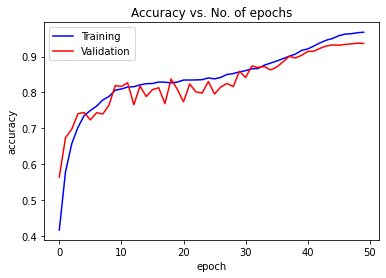

In [17]:
plot_accuracies(history)

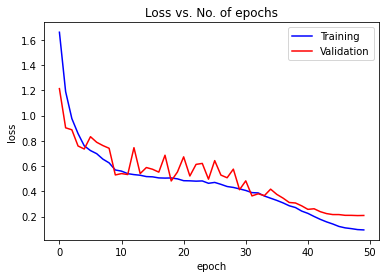

In [ ]:
plot_losses(history)

* The training seems to have stopped at roughly the right time, indicated by the accuracy and loss curves that have turned flat.
* The gap between the training and validation performance, both in loss and accuracy, is relatively small, indicating thet the model has not began to overift.

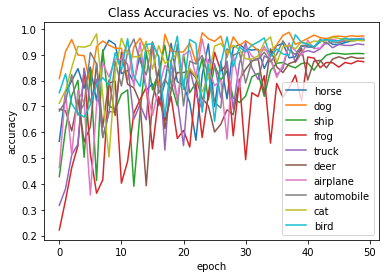

In [19]:
plot_per_cls_accuracies(history)

* While there is substantial variation in accuracies of different classes in the earlier part of the trading period, the accuracies begin to converge around the 40th ecpoh.
* The model identifies dogs with the best accuracy throughout the training, while having the hardest time with frogs.

## **Evaluate model with single images**


In [20]:
class SingleImagePredictor:
    def __init__(self, model, device=device):
        self.model = model.to(torch.device('cpu'))

    def get_pred_cls_name(self, img):
        preds = self.model(img)
        pred_val, pred_cls = torch.max(preds, dim=1)
        pred_cls_name = train_ds.classes[pred_cls.item()]
        return pred_cls_name
      
    def predict(self, sample):
        img, label = sample
        img = img.unsqueeze(0)                           # Add the batch dimension: from 3 x 32 x 32 to 1 x 3 x 32 x 32
        pred_cls_name = self.get_pred_cls_name(img)      # Predict class and return class name
        true_cls_name = train_ds.classes[label]          # Get the correct class name
        print(f'Predicted: {pred_cls_name}. True: {true_cls_name}.')
        img_denorm = denormalize(img, *stats)
        plt.imshow(img_denorm.squeeze(0).permute(1, 2, 0)) # Squeeze / remove batch dimension
        plt.show()

In [21]:
predictor = SingleImagePredictor(model)

Predicted: airplane. True: airplane.


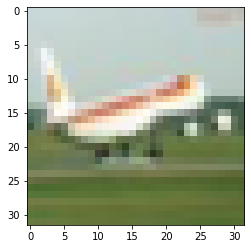

In [22]:
img_idx = 100
predictor.predict(valid_ds[img_idx])

Predicted: automobile. True: automobile.


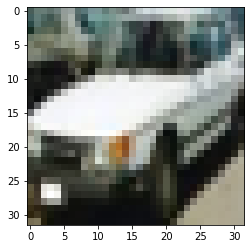

In [23]:
img_idx = 1200
predictor.predict(valid_ds[img_idx])

Predicted: bird. True: bird.


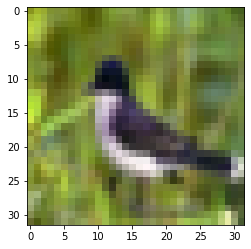

In [24]:
img_idx = 2300
predictor.predict(valid_ds[img_idx])

Predicted: dog. True: dog.


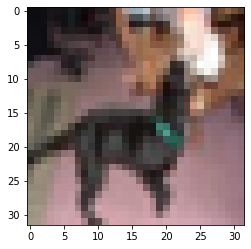

In [25]:
img_idx = 5400
predictor.predict(valid_ds[img_idx])

# **Load model for inference**

Model can be loaded either as a single object (first cell) or through chekcpoint, by loading the state dictionaries of the model and the optimizer (second cell).

In [26]:
# Load entire model
model = torch.load('model.pth')
model = model.to(device)

In [27]:
# Load model through checkpoint (assumes model is saved on GPU)

# Define model and optimizer first
model = ResNetClassifier(in_channels=3, num_classes=10)
optim = torch.optim.Adam(model.parameters())

# Load checkpoint
if device == torch.device('cuda'):
    cp = torch.load('checkpoint.pth', map_location=torch.device('cuda'))
else:
    cp = torch.load('checkpoint.pth', map_location=torch.device('cpu'))

epoch = cp['epoch']
model_state = cp['model_state']
optim_state = cp['optimizer_state']

# Load state dict to model
model.load_state_dict(model_state)
optim.load_state_dict(optim_state)

# Move to device
model = model.to(device)
model.eval()

ResNetClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(i

Predicted: bird. True: bird.


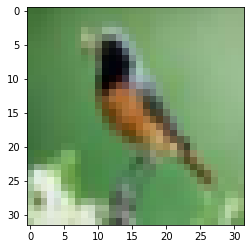

In [29]:
# Predict with loaded model to confirm that everything works as intended
predictor.predict(valid_ds[2005])